# Identificate some Wolrd3 equations with SINDy
- Began on the 3/11

## Take data from pyworld3


In [1]:
# imports
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from jupyter_utils import storerun
import pysindy as ps

In [2]:
# ATTTENTION A CE QUE PYWORLD3 SOIT EN BONNE BRANCHE DU GIT
world3_path = "/home/achille/Bureau/couillet/world3/pyworld3/pyworld3"
if world3_path not in sys.path:
    sys.path.append(world3_path)
from pyworld3 import World3
from pyworld3.utils import plot_world_with_scales, variable_definitions

In [3]:
# Run
w = World3(dt=1)
w.init_world3_constants()
w.init_world3_variables()
w.set_world3_table_functions()
w.set_world3_delay_functions()
w.run_world3()
# plot_world_with_scales(w)

In [21]:
w.ones = np.ones(len(w.time))
# Choose data and parameters
Tt = 200
x_names, y_names = ['iopc'], ['pop', 'ppolx', 'f', 'io', 'nr']
X = np.vstack([x[:Tt]/np.linalg.norm(x[:Tt]) for x in (w.__getattribute__(x_name) for x_name in x_names)])
Y = np.vstack([y[:Tt]/np.linalg.norm(y[:Tt]) for y in (w.__getattribute__(y_name) for y_name in y_names)])

iopc : industrial output per capita [dollars/person-year].
pop : population [persons].
ppolx : index of persistent pollution [].
f : food [vegetable-equivalent kilograms/year].
io : industrial output [dollars/year].
nr : nonrenewable resources [resource units]. It is a state variable.


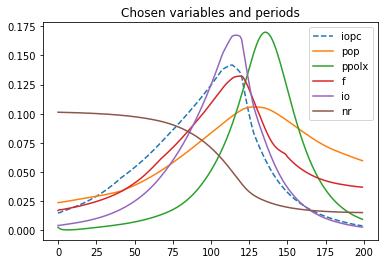

In [22]:
# Plot what is chosen
fig = plt.figure()
plot1 = fig.add_subplot(title="Chosen variables and periods")
plt.plot(X.T, linestyle = '--')
plt.plot(Y.T, linestyle='-')
plt.legend(x_names + y_names)
for x_name in x_names:
    if x_name not in {'zeros', 'ones'}:
        print(x_name, ':', variable_definitions[x_name])
for y_name in y_names:
    print(y_name, ':', variable_definitions[y_name])

## 11.10 SINDy first implementation

In [60]:
data = Y.T
threshold=0.001
stlsq_optimizer = ps.STLSQ(threshold=threshold, alpha=0.5) # threshold increases sparcity
f_lib =  None #ps.IdentityLibrary() 
model = ps.SINDy(feature_names= y_names, 
#                  feature_library=f_lib,
                 optimizer=stlsq_optimizer)
t = np.arange(Tt)
model.fit(data, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['pop', 'ppolx', 'f', 'io', 'nr'],
      optimizer=STLSQ(alpha=0.5, threshold=0.001))

In [61]:
model.print()

pop' = -0.011 ppolx + 0.012 io + 0.002 nr
ppolx' = -0.018 1 + 0.055 pop + -0.205 ppolx + 0.417 f + -0.628 io + 0.113 nr + 14.153 pop io + -0.644 ppolx io + -0.353 f^2 + -8.408 f io + 1.693 io^2
f' = 0.009 pop + -0.001 ppolx + -0.023 f + 0.023 io + 0.008 nr + -0.134 ppolx^2
io' = 0.156 pop + 0.222 ppolx + -0.290 f + 0.220 io + 0.005 nr + -4.597 pop ppolx + 1.015 ppolx^2 + 1.012 ppolx f + -0.896 ppolx io
nr' = 0.003 f + -0.012 io


/home/achille/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


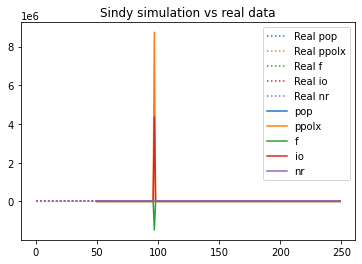

In [62]:
start_date = 50
end_date = start_date + 200
simu_range = np.arange(start_date, end_date)
pred = model.simulate(Y.T[start_date], simu_range)
plt.plot(Y.T, linestyle = ':', label  = 'Real data')
plt.gca().set_prop_cycle(None)
plt.plot(simu_range, pred, label = 'Simulated')
plt.legend(['Real ' + n for n in y_names] + y_names)
plt.title('Sindy simulation vs real data');
# storerun('SINDy', "start_date, end_date, y_names, identity_library, Tt, stlsq_optimizer", globals())

## 11.15 Use custom features library or optimizers
- Can make a custom functions library using function, or class: <https://pysindy.readthedocs.io/en/latest/_modules/pysindy/feature_library/custom_library.html?highlight=base%20feature%20library>
- Another optimizer, base optimizer class for SINDy: <https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html#pysindy.optimizers.base.BaseOptimizer>

## 11.19 Try to force a simple family

## With simple linear regression
But not for differential equations

In [55]:
# Choose data and parameters
x_names, y_names = ['iopc'], ['lfd', 'ppolx']

Fl = 30
Tr = 90
Si = len(w.pop) - Fl - Tr
Tt = Fl + Tr + Si

X = np.vstack([x[:Tt]/np.linalg.norm(x[:Tt]) for x in (w.__getattribute__(x_name) for x_name in x_names)])
Y = np.vstack([y[:Tt]/np.linalg.norm(y[:Tt]) for y in (w.__getattribute__(y_name) for y_name in y_names)])

In [75]:
data = np.vstack((Y.T[:-1].T)).T
data_noised = data + np.random.normal(0,0.0001, size=data.shape)
w_out = np.dot(np.linalg.pinv(data_noised), X.T[1:] - X.T[:-1])

In [71]:
## simulation
X_sim = np.zeros((Tt))
X_sim[0] = X.T[0]
for i in range(Tt):
    X_sim[i] = X_sim[i-1] + np.dot(w_out.T, Y.T[i-1])

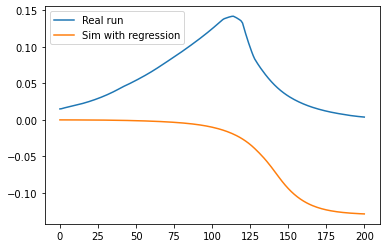

In [74]:
dt = 1
w_euh = np.array([1, dt, -dt])
plt.plot(X.T, label='Real run')
plt.plot(X_sim, label='Sim with regression')
# plt.plot(np.dot(data2 , w_euh), label='Simulation with true parameters')
plt.legend()

## Notes:
- Wrong results when I put X in function of the others (but fits the shape)
    - Because enormous correlation between $X$ and $Y$
- Write results when I put differentiation ($X_i - X_{i-1}$)